In [17]:
#import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install albumentations

zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'


Importing Required Libraries

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import albumentations as A
from albumentations import (
    Compose, RandomRotate90, VerticalFlip, Transpose,
    OneOf, GaussNoise, RandomBrightnessContrast
)

Importing Data from 'Train' folder 

In [8]:
# Importing data from the 'Train' Folder
data = r'Train'
# Creating empty list to store filenames
files = []
# Iterating through the data and storing the filenames in the files list
for _, _, files in os.walk(data):
    break
# Printing the total number of images currently being used to train and test the models below
print(f'Total number of files: {len(files)}')


Total number of files: 971


In [25]:
#Bootstrap function : Perform bootstrapping on a list of images and return the new bootstrap list
def bootstrap(imageList, n_samples):
    result = [np.random.choice(imageList) for _ in range(n_samples)]
    return result

#Defining the data augmentation transform variable
transforms = Compose([
    RandomRotate90(p=0.5),
    VerticalFlip(p=0.5),
    OneOf([
        GaussNoise(),
        RandomBrightnessContrast(),
    ], p=0.5),
])

def bootstrap_and_data_augmentation(imageList, n_sample, n_augmentations):
    #TO DO:
    bootstrap_images = bootstrap(imageList=imageList, n_samples=n_sample)


In [33]:
bootstrap_images_sample_size_5000 = bootstrap(files,5000)

bootstrap_images_sample_size_10000 = bootstrap(files,10000)

Classifying the images based on the labels in the filename

Something to note, I originally created the array of just size 1 that stored the value of each label in that single spot as 0,1,2 but it resulted in accuracy ratings never changing between epochs and being lower after trying different techniques this is the current attempt that is having the best results, currently values are stored in a numpy array of size 3 where the first value being 1 represents a lower class, the second being 1 represents middle and the third being 1 represents upper class.

What Y looks like
Y = ([[1. 0. 0.], [0. 1. 0.], [0. 0. 1.]])

In [34]:


def image_label_classification( files):
    # Creating a numpy array of zeros the length of the dataset with a size of shape of 3
    Y = np.zeros((len(files), 3))

    # Loop through the list of filenames
    for i, f in enumerate(files):

        # If the filename contains 'lower' set the first value of the array to 1
        if 'lower' in f:
            Y[i, 0] = 1  
        # If the filename contains 'middle' set the second value of the array to 1
        elif 'middle' in f:
            Y[i, 1] = 1  
        # If the filename contains 'upper' set the third value of the array to 1
        elif 'upper' in f:
            Y[i, 2] = 1  

    #Create the path to each file 
    files = [os.path.join(data, f) for f in files]

    #Example showing the path to the file and the coorisponding label showing what we have classified as middle in the numpy array.
    print(f'File location: {files[1]}\n Classified as: {Y[1]}')
    # Printing the total number of images currently being used to train and test the models below
    print(f'Total number of files: {len(files)}')
    return files

In [35]:
#Raw image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files = image_label_classification(files)

#5000 bootstrap image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_bootstrap_images_sample_size_5000 = image_label_classification(bootstrap_images_sample_size_5000)

#10000 bootstrap image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_bootstrap_images_sample_size_10000 = image_label_classification(bootstrap_images_sample_size_10000)

File location: Train/Train/Train/Train/img569_lower.jpg
 Classified as: [1. 0. 0.]
Total number of files: 971
File location: Train/Train/Train/Train/img1820_lower.png
 Classified as: [1. 0. 0.]
Total number of files: 5000
File location: Train/Train/Train/Train/img1724_lower.png
 Classified as: [1. 0. 0.]
Total number of files: 10000


# Creating a Sequential model 
This runs for multiple image sizes to determine the Evaluation scores based on image size

In [10]:
# List of image sizes
image_size = [(16, 16), (32, 32), (64, 64), (150, 150), (250, 250), (500, 500)]

# Epoch count, currently anything over 5 epochs does not result in any change in the accuracy rating
epochs = 5

# Creating a list to store the image sizes and accuracy ratings for the Sequential Model
conv_accuracy_results = []

# Looping through each image size
for size in image_size:

    # Creating a list of each images numerical values
    X = []

    for file in files:
        img = cv2.imread(file) 
        # Resizing the image based on the specific tuple in image_sizes
        img = cv2.resize(img, size) 
        X.append(img)

    # Scaling the image data down to values between 0 and 1
    X = np.array(X, dtype='float32') / 255

    # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

    # Creating a Sequential Convolution Neural Network model with 2 layers
    model = models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (size[0], size[1], 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = (size[0], size[1], 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # Dense layer of size 3 to match the input size of the numpy array Y
    layers.Dense(3, activation='softmax')
    ])

    # Compiling the model utilizing the adam optimizer and categorical crossentropy 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
    model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_split=0.2)
    
    # Predicting the outputs of the test data using the model
    y_pred = model.predict(X_test)

    # Converting the One-Hot labels into class indices so they can be used to for evaluation
    Y_test_classes = np.argmax(Y_test, axis=1)
    Y_pred_classes = np.argmax(y_pred, axis = 1)

    # Calculating Evaluation Metrics
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
    recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
    f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
    classification_rep = classification_report(Y_test_classes,Y_pred_classes)
    
    # Appending all the evaluation metrics into the conv_accuracy_results list
    conv_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

    # Printing the Classification Report for that image size
    print(f'Image Size: {size}')
    print(classification_rep)

    

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4199 - loss: 1.0348 - val_accuracy: 0.4615 - val_loss: 1.0348
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4649 - loss: 0.9936 - val_accuracy: 0.4038 - val_loss: 1.0481
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4713 - loss: 0.9905 - val_accuracy: 0.4295 - val_loss: 1.0419
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4440 - loss: 0.9981 - val_accuracy: 0.4038 - val_loss: 1.0506
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4598 - loss: 1.0033 - val_accuracy: 0.4423 - val_loss: 1.0427
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Image Size: (16, 16)
              precision    recall  f1-score   support

           0       0.67      0.02      0.04        88
           1       0.43      0.99      0.60        84
           2       0.00      0.00      0.00        23

    accuracy                           0.44       195
   macro avg       0.37      0.34      0.22       195

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3365 - loss: 1.0508 - val_accuracy: 0.4295 - val_loss: 1.0309
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4773 - loss: 0.9978 - val_accuracy: 0.4295 - val_loss: 1.0317
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4419 - loss: 1.0064 - val_accuracy: 0.4808 - val_loss: 1.0321
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5219 - loss: 1.0128 - val_accuracy: 0.4487 - val_loss: 1.0320
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4729 - loss: 0.9840 - val_accuracy: 0.5321 - val_loss: 1.0200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.65      0.27      0.38        88
           1       0.48      0.90      0.63        84
           2       0.00      0.00      0.00        23

    accuracy                           0.51       195
   macro avg       0.38      0.39      0.34       195

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3145 - loss: 1.1368 - val_accuracy: 0.4038 - val_loss: 1.0699
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4608 - loss: 1.0382 - val_accuracy: 0.4295 - val_loss: 1.0301
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5005 - loss: 0.9900 - val_accuracy: 0.5192 - val_loss: 1.0288
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5650 - loss: 0.9843 - val_accuracy: 0.4615 - val_loss: 1.0692
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6087 - loss: 0.9291 - val_accuracy: 0.4615 - val_loss: 1.0703
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.47      0.52      0.49        88
           1       0.48      0.56      0.52        84
           2       0.00      0.00      0.00        23

    accuracy                           0.48       195
   macro avg       0.32      0.36      0.34      

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.3957 - loss: 1.9137 - val_accuracy: 0.4038 - val_loss: 1.0729
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.4758 - loss: 1.0440 - val_accuracy: 0.4295 - val_loss: 1.0473
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.5160 - loss: 0.9634 - val_accuracy: 0.4615 - val_loss: 1.0212
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6432 - loss: 0.9380 - val_accuracy: 0.4167 - val_loss: 1.0677
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.5780 - loss: 0.8776 - val_accuracy: 0.4872 - val_loss: 1.0429
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.47      0.80      0.59        88
           1       0.49      0.26      0.34        84
           2       0.00      0.00      0.00        23

    accuracy                           0.47       195
   macro avg       0.32      0.35      0.3

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - accuracy: 0.3652 - loss: 7.8051 - val_accuracy: 0.4359 - val_loss: 1.0647
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.4586 - loss: 1.0743 - val_accuracy: 0.4231 - val_loss: 1.0798
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.4919 - loss: 1.0384 - val_accuracy: 0.4679 - val_loss: 1.0325
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.5760 - loss: 0.9567 - val_accuracy: 0.4487 - val_loss: 1.0782
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.7165 - loss: 0.7585 - val_accuracy: 0.4295 - val_loss: 1.0591
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.47      0.52      0.50        88
           1       0.44      0.46      0.45        84
           2       0.30      0.13      0.18        23

    accuracy                           0.45       195
   macro avg       0.41      0.37      0.3

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4225 - loss: 18.5897 - val_accuracy: 0.4551 - val_loss: 1.0737
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5395 - loss: 1.0485 - val_accuracy: 0.4103 - val_loss: 1.1342
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5743 - loss: 0.9018 - val_accuracy: 0.5064 - val_loss: 1.0665
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8459 - loss: 0.5264 - val_accuracy: 0.4551 - val_loss: 1.2674
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9775 - loss: 0.3564 - val_accuracy: 0.4231 - val_loss: 1.3925
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.47      0.94      0.63        88
           1       0.53      0.12      0.19        84
           2       0.00      0.00      0.00        23

    accuracy                           0.48       195
   macro avg       0.33      0.35      0

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

# Graphing the Accuracy Ratings
Something to note and look at later, I have ran this multiple times and each output is significantly different, sometimes prefering a smaller image size and sometimes prefering larger.

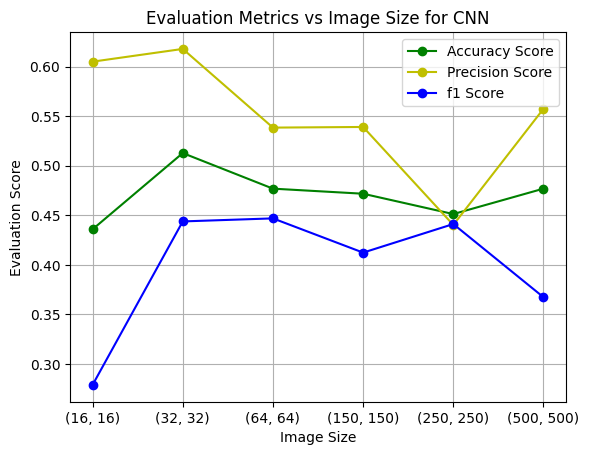

In [12]:
# Creating variables for each item in conv_accuracy_results
sizes, acc, prec, recall, f1, classrep = zip(*conv_accuracy_results)

# Converting the image sizes into a string so they can be used for the X axis
sizes = [str(size) for size in sizes]

# Plot showing the Evaluation Metrics vs Image Size
plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
# Not using recall as it is identical to the accuracy rating when tested currently
#plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
plt.title('Evaluation Metrics vs Image Size for CNN')
plt.xlabel('Image Size')
plt.ylabel('Evaluation Score')
plt.legend()
plt.grid()
plt.show()

# Creating the ResNet Model
This runs for multiple image sizes to determine the Evaluation Scores based on image size

In [13]:
# List of image sizes
image_size = [(32, 32), (64, 64), (150, 150), (250, 250), (500, 500)]

# Epoch count, currently set to 5
epochs = 5

# Creating a list to store the image sizes and accuracy ratings for the ResNet model
resNet_accuracy_results = []

# Looping through each image size
for size in image_size:
    # Creating a list of each images numerical values
    X = []

    for file in files:
        img = cv2.imread(file) 
        # Resizing the image based on the specific tuple in image_sizes
        img = cv2.resize(img, (size[0], size[1]))  
        X.append(img)

    # Scaling the image data down to values between 0 and 1
    X = np.array(X, dtype='float32') / 255.0
    
    # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

    # Creating a ResNet50V2 model, weights are based off the imagenet dataset and the input shape is set to the image size, currently only doing two layers
    resbase = applications.ResNet50V2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))
    # Allows only the new layers to be trainable
    resbase.trainable = False
    # Creating the sequential model utilziing the ResNet model instantiated before and adding more layers to be trained based on the current dataset
    # Currently attempting with only 1 extra layer
    resModel = models.Sequential([
        # Calling the resbase which was assigned to the ResNet model created before
        resbase,

        # Adding our extra layers to be trained
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation= 'relu', input_shape = (size[0], size[1], 3)),
        
        # Dense layer of size 3 to match the input size of the numpy array Y
        layers.Dense(3, activation='softmax')
    ])
    
    # Compiling the model utilizing the adam optimizer and categorical crossentropy 
    resModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
    resModel.fit(X_train, Y_train, epochs = epochs, batch_size=64, validation_split=0.2)

    # Predicting the outputs of the test data using the model
    y_pred = resModel.predict(X_test)
    
    # Converting the One-Hot labels into class indices so they can be used to for evaluation
    Y_test_classes = np.argmax(Y_test, axis=1)
    Y_pred_classes = np.argmax(y_pred, axis = 1)
    
    # Calculating Evaluation Metrics
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
    classification_rep = classification_report(Y_test_classes,Y_pred_classes)

     # Appending all the evaluation metrics into the resNet_accuracy_results list
    resNet_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

    # Printing the Classification Report for that image size
    print(f'Image Size: {size}')
    print(classification_rep)

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4065 - loss: 1.0773 - val_accuracy: 0.4615 - val_loss: 1.0840
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5982 - loss: 0.9040 - val_accuracy: 0.4615 - val_loss: 1.0831
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6527 - loss: 0.8627 - val_accuracy: 0.5000 - val_loss: 1.0610
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6732 - loss: 0.7935 - val_accuracy: 0.4744 - val_loss: 1.0602
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6941 - loss: 0.7399 - val_accuracy: 0.4679 - val_loss: 1.0727
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.54      0.66      0.59        88
           1       0.48      0.49      0.49        84
           2       0.50      0.04      0.08        23

    accuracy                           0.51       195
   macro avg       0.51      0.40      0.39     

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.4143 - loss: 1.4750 - val_accuracy: 0.3654 - val_loss: 1.2865
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6767 - loss: 0.7782 - val_accuracy: 0.4808 - val_loss: 1.2252
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7833 - loss: 0.5378 - val_accuracy: 0.4679 - val_loss: 1.3488
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8630 - loss: 0.3950 - val_accuracy: 0.4359 - val_loss: 1.3501
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9329 - loss: 0.2845 - val_accuracy: 0.4936 - val_loss: 1.3774
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.50      0.73      0.59        88
           1       0.48      0.31      0.38        84
           2       0.50      0.26      0.34        23

    accuracy                           0.49       195
   macro avg       0.49      0.43      0.44

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 463ms/step - accuracy: 0.4411 - loss: 1.6927 - val_accuracy: 0.4615 - val_loss: 1.3114
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.6376 - loss: 0.7675 - val_accuracy: 0.4808 - val_loss: 1.0997
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step - accuracy: 0.7558 - loss: 0.5886 - val_accuracy: 0.4936 - val_loss: 1.1842
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.8507 - loss: 0.4604 - val_accuracy: 0.4936 - val_loss: 1.1769
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.9098 - loss: 0.3493 - val_accuracy: 0.4679 - val_loss: 1.2082
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.58      0.66      0.62        88
           1       0.49      0.42      0.45        84
           2       0.17      0.17      0.17        23

    accuracy                           0.50       195
   macro avg       0.41      0.42      0.

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4654 - loss: 1.3207 - val_accuracy: 0.5000 - val_loss: 1.1007
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 998ms/step - accuracy: 0.6089 - loss: 0.8427 - val_accuracy: 0.4615 - val_loss: 1.0229
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 997ms/step - accuracy: 0.7013 - loss: 0.6731 - val_accuracy: 0.5256 - val_loss: 1.0171
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 995ms/step - accuracy: 0.7643 - loss: 0.5721 - val_accuracy: 0.5000 - val_loss: 1.0425
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 996ms/step - accuracy: 0.8049 - loss: 0.4727 - val_accuracy: 0.4551 - val_loss: 1.0643
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.57      0.74      0.64        88
           1       0.60      0.44      0.51        84
           2       0.47      0.39      0.43        23

    accuracy                           0.57       195
   macro avg       0.55      0.52      

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.3807 - loss: 1.5359 - val_accuracy: 0.4679 - val_loss: 1.0378
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.5792 - loss: 0.8668 - val_accuracy: 0.4679 - val_loss: 0.9645
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.6391 - loss: 0.8232 - val_accuracy: 0.4936 - val_loss: 0.9803
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.6764 - loss: 0.7584 - val_accuracy: 0.4872 - val_loss: 0.9576
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.7363 - loss: 0.6538 - val_accuracy: 0.4936 - val_loss: 0.9838
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        88
           1       0.56      0.74      0.64        84
           2       0.78      0.30      0.44        23

    accuracy                           0.61       195
   macro avg       0.66      0.53      0.56       195

# Graphing the Accuracy Ratings of the ResNet Model

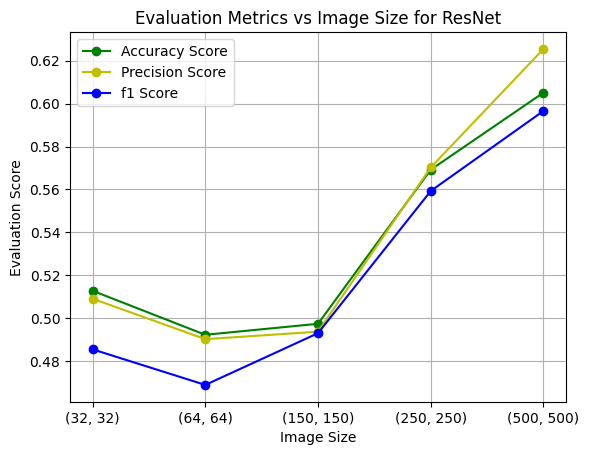

In [14]:
# Creating variables for each item in conv_accuracy_results
sizes, acc, prec, recall, f1, classrep = zip(*resNet_accuracy_results)

# Converting the image sizes into a string so they can be used for the X axis
sizes = [str(size) for size in sizes]

# Plot showing the Evaluation Metrics compared to Image size
plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
# Not using recall as it is identical to the accuracy rating when tested currently
#plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
plt.title('Evaluation Metrics vs Image Size for ResNet')
plt.xlabel('Image Size')
plt.ylabel('Evaluation Score')
plt.legend()
plt.grid()
plt.show()